# Cyber Bullying Classification 

## Goal: 

In [59]:
# Foundational Libraries
import pandas as pd 
import numpy as np 

# All Text Pre-Proccessing Libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.tokenize import word_tokenize
import string

from tqdm import tqdm # For Progress
import concurrent.futures


# Read in Dataset
df = pd.read_csv('cyberbullying_tweets.csv')
print(df.info)


<bound method DataFrame.info of                                               tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[47692 rows x 2 columns]>


Taken below code from: 
https://github.com/NumericCamel/Crypto/blob/main/scripts/sentiment_analyzer.py

In [63]:
blacklist = []
# Ensure nltk resources are downloaded
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Initialize stopwords and SentimentIntensityAnalyzer
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuationaa
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text using spaCy's nlp pipeline
    tokens = nlp(text)
    
    # Remove stop words and non-alphabetic tokens, and perform lemmatization
    tokens = [token.lemma_ for token in tokens if token.is_alpha and token.text not in stop_words and token.text not in blacklist]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [51]:
def apply_preprocessing(df):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Submit all jobs, storing futures along with the index to preserve order
        futures = {executor.submit(preprocess_text, text): index for index, text in enumerate(df['tweet_text'])}
        results = [None] * len(df)  # Create a results list of the correct size

        # As each future completes, place the result in the correct position
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Text"):
            index = futures[future]  # Get the original index
            results[index] = future.result()
    
    # Create a new DataFrame with the results
    processed_df = df.copy()
    processed_df['preprocessed_text'] = results
    return processed_df

In [55]:
thous_df = df.sample(n=1000)
thous_df.tail(3)

,tweet_text,cyberbullying_type
15542,"There was certainly a more ""acceptable"" time f...",gender
47272,I can’t think of much of anything past the jux...,ethnicity
12611,my favoritei s the fact he listed both feminaz...,gender


In [64]:
thous_df['Processed-Text'] = thous_df['tweet_text'].apply(preprocess_text)

In [65]:
thous_df

,tweet_text,cyberbullying_type,Processed-Text
22502,"@dankmtl No, the problem of the Palestinians a...",religion,dankmtl problem palestinians muslim stand jewi...
3252,"@Cam_Matthews97 No, in fact there are lots of ...",not_cyberbullying,fact lot sexist feel way
19965,Btw I have no idea where you're getting this B...,religion,btw idea get bs conservative antimuslim antise...
31997,king princess- let’s non lesbian friends use t...,age,king princess let non lesbian friend use slur ...
31907,all you bullies that was rude to me in school,age,bully rude school
...,...,...,...
7577,Oh bless. Little lines. Sand. Micro herbs. Ble...,not_cyberbullying,oh bless little line sand micro herb bless ble...
6467,RT @deansgaljo: Crossing my fingers for the #k...,not_cyberbullying,rt deansgaljo cross finger killerblonde get ri...
15542,"There was certainly a more ""acceptable"" time f...",gender,certainly acceptable time make though eye worl...
47272,I can’t think of much of anything past the jux...,ethnicity,can think much anything past juxtaposition lor...


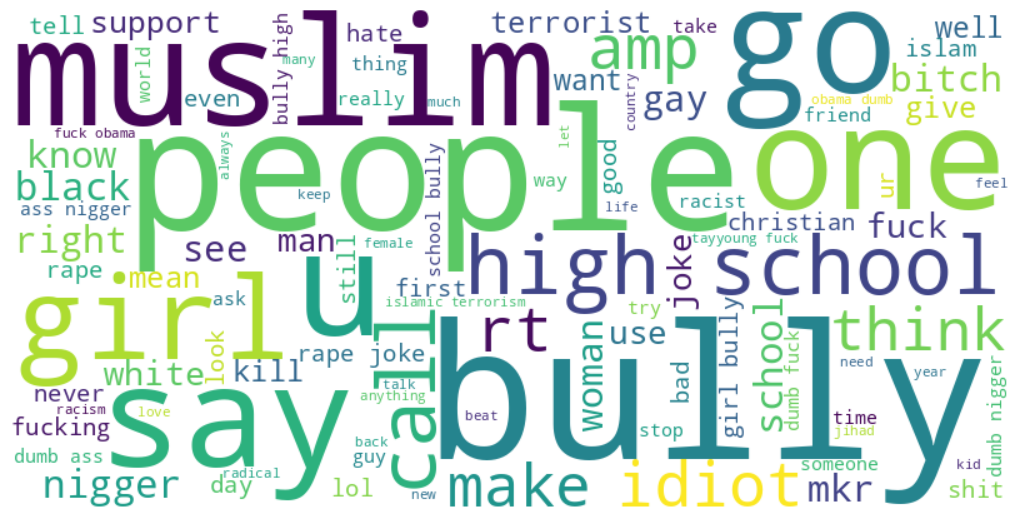

In [70]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all processed texts
text = " ".join(review for review in thous_df['Processed-Text'])

# Create WordCloud object
wordcloud = WordCloud(
    width = 800,
    height = 400,
    background_color='white',
    #stopwords=STOPWORDS,
    max_font_size=150,
    max_words=100
).generate(text)

# Display the generated image
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()